In [1]:
rki <- read.csv("data/covid19-deu.csv")
rki$T <- as.POSIXct(rki$T)
str(rki)

'data.frame':	22706 obs. of  7 variables:
 $ X  : num  9.44 9.44 9.44 9.44 9.44 ...
 $ Y  : num  54.8 54.8 54.8 54.8 54.8 ...
 $ T  : POSIXct, format: "2020-03-14" "2020-03-19" ...
 $ LK : Factor w/ 412 levels "LK Ahrweiler",..: 336 336 336 336 336 336 336 336 336 336 ...
 $ ID : int  1001 1001 1001 1001 1001 1001 1001 1001 1001 1001 ...
 $ POP: int  89504 89504 89504 89504 89504 89504 89504 89504 89504 89504 ...
 $ N  : int  4 4 1 1 1 1 1 1 1 2 ...


In [2]:
require(rgdal)
state <- readOGR("data/BL_mit_EW_und_Faellen.shp")
district <- readOGR("data/Landkreise.shp")

Loading required package: rgdal

Loading required package: sp

rgdal: version: 1.4-7, (SVN revision 845)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 2.2.2, released 2017/09/15
 Path to GDAL shared files: /usr/share/gdal/2.2
 GDAL binary built with GEOS: TRUE 
 Loaded PROJ.4 runtime: Rel. 4.9.2, 08 September 2015, [PJ_VERSION: 492]
 Path to PROJ.4 shared files: (autodetected)
 Linking to sp version: 1.3-2 



OGR data source with driver: ESRI Shapefile 
Source: "/home/frantzda/cor/covid19/data/BL_mit_EW_und_Faellen.shp", layer: "BL_mit_EW_und_Faellen"
with 16 features
It has 14 fields
OGR data source with driver: ESRI Shapefile 
Source: "/home/frantzda/cor/covid19/data/Landkreise.shp", layer: "Landkreise"
with 412 features
It has 39 fields


In [3]:
#date_uni <- sort(unique(rki$T))
#date_lim <- range(date_uni)
#date_lim

# Total cases Germany

In [4]:
plot_cases <- function(x, add=FALSE, col=1, LK=NA){
    if (!is.na(LK)) x <- x[grep(LK, x$LK),]
    date_lim <- c(as.POSIXct("2020/01/01"), Sys.time())
    date_uni_ <- sort(unique(x$T))
    daily_ <- sapply(split(x$N, x$T), sum)
    if (!add){
        plot(date_uni_, cumsum(daily_), xlim=date_lim, type="l", xlab="", ylab="total COVID-19 cases", col=col)
    } else {
        lines(date_uni_, cumsum(daily_), col=col)
    }
}

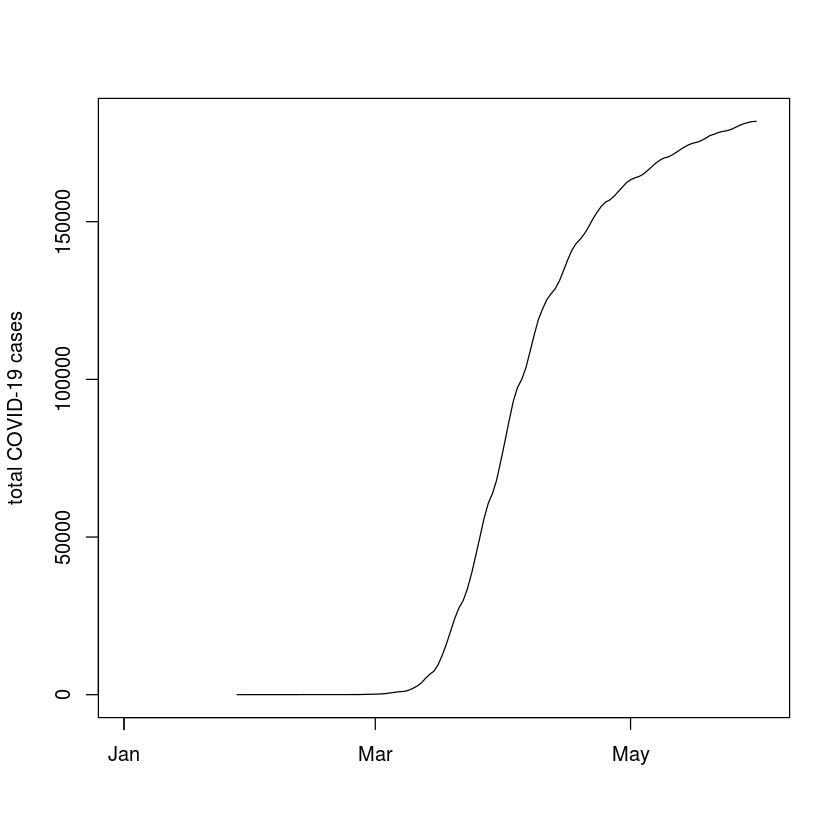

In [5]:
plot_cases(rki)

In [6]:
#daily <- sapply(split(rki$N, rki$T), sum)
#plot(date_uni, cumsum(daily), xlim=date_lim, type="l", xlab="", ylab="total COVID-19 cases")

# Total cases for some districts

Warning message in if (!is.na(LK)) x <- x[grep(LK, x$LK), ]:
“the condition has length > 1 and only the first element will be used”
Warning message in grep(LK, x$LK):
“argument 'pattern' has length > 1 and only the first element will be used”


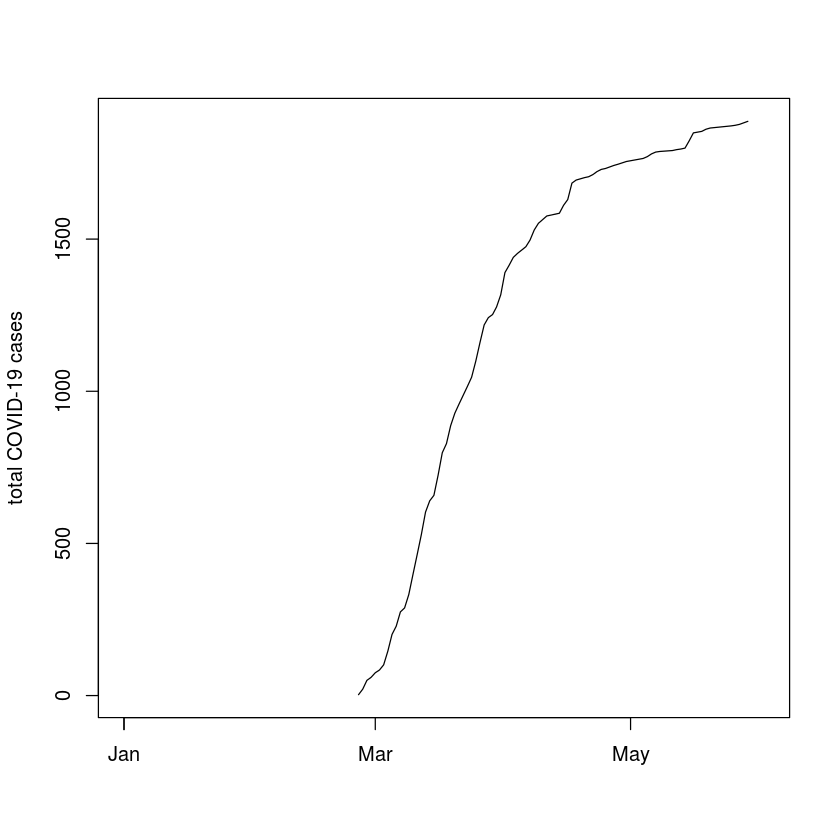

In [7]:
LK <- c("Heinsberg", "Coesfeld", "Trier")
plot_cases(rki, LK=LK)

In [8]:
#rki_ <- rki[grep(LK[2], rki$LK),]
#rki_

In [9]:
#ncase <- dim(rki)[1]

rki_ <- rki[rki$N>10,]

#mat <- cbind(rki$X+rnorm(ncase, 0, 0.1), rki$Y+rnorm(ncase, 0, 0.1), rki$T)
mat <- cbind(rki_$X, rki_$Y, as.numeric(format(rki_$T, "%j"))/7.0)
str(mat)
#mat <- cbind(rki$X, rki$Y)
#mat <- scale(mat)


 num [1:4900, 1:3] 10.1 10.1 10.1 10.1 10.1 ...


Loading required package: dbscan



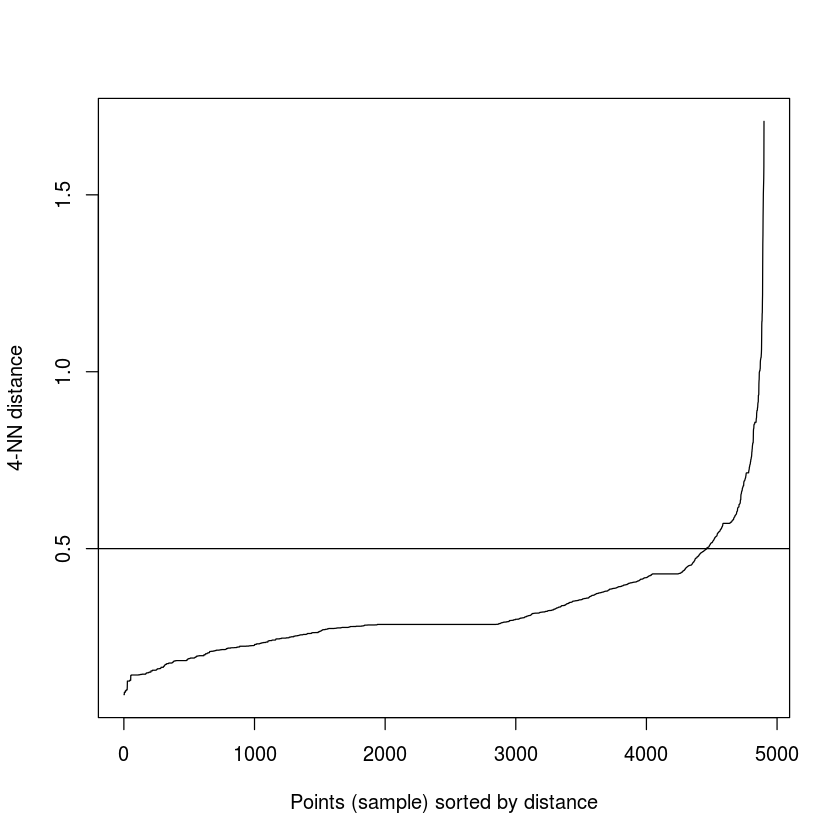

In [10]:
require(dbscan)

kNNdistplot(mat, k=4)
#kNNdistplot(as.matrix(unique(mat[,1:3])), k=4)
abline(h=0.5)
#kNNdistplot(as.matrix(unique(mat[,1:2])), k=3)
#kNNdistplot(as.matrix(unique(mat[,3])), k=2)

#abline(h=0.1)

In [11]:
res <- dbscan(mat, eps = 0.5, minPts = 4)
res

DBSCAN clustering for 4900 objects.
Parameters: eps = 0.5, minPts = 4
The clustering contains 25 cluster(s) and 165 noise points.

   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
 165  145   18 4065   10    8    5   33    5   13    8    4   14    3    8    4 
  16   17   18   19   20   21   22   23   24   25 
  64   18    6    4   15  260   13    4    4    4 

Available fields: cluster, eps, minPts

In [12]:
rki_ <- cbind(rki_, cluster=res$cluster)
str(rki_)

'data.frame':	4900 obs. of  8 variables:
 $ X      : num  10.1 10.1 10.1 10.1 10.1 ...
 $ Y      : num  54.3 54.3 54.3 54.3 54.3 ...
 $ T      : POSIXct, format: "2020-04-20" "2020-03-23" ...
 $ LK     : Factor w/ 412 levels "LK Ahrweiler",..: 359 359 359 359 359 359 359 359 367 367 ...
 $ ID     : int  1002 1002 1002 1002 1002 1002 1002 1002 1003 1003 ...
 $ POP    : int  247548 247548 247548 247548 247548 247548 247548 247548 217198 217198 ...
 $ N      : int  14 11 12 11 14 12 11 11 23 18 ...
 $ cluster: int  0 1 1 1 1 1 1 1 1 1 ...


In [13]:
rki_clus <- split(rki_, rki_$cluster)
#str(rki_clus)

In [14]:
size <- sapply(rki_clus, dim)[1,]
rki_clus <- rki_clus[order(size, decreasing=TRUE)]
#str(rki_clus)

In [15]:
size <- sapply(rki_clus, dim)[1,]
big <- size > 0 & names(rki_clus) != 0
sum(big)

rki_clus <- rki_clus[big]
size <- size[big]

[1] 25

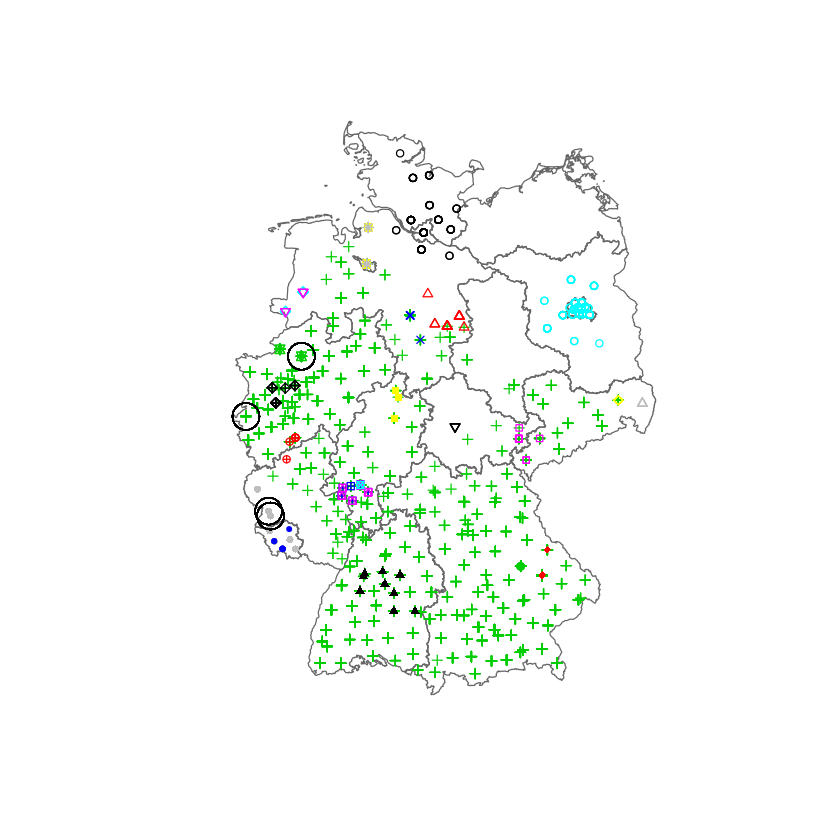

In [16]:
plot(state, border="grey40")
#tmp <- sapply(rki_clus, function(clus) points(clus$X, clus$Y, col=clus$cluster+1L, pch=19, cex=0.8))
tmp <- sapply(rki_clus, function(clus) points(clus$X, clus$Y, col=clus$cluster, pch=clus$cluster, cex=0.8))

LK <- c("Trier", "Heinsberg", "Coesfeld")
for (i in 1:3){
    tmp <- rki[grep(LK[i], rki$LK),]
    points(tmp$X, tmp$Y, cex=3)
}



In [17]:
sapply(rki_clus, function(x) unique(x$LK))

$`3`
  [1] SK Braunschweig                     SK Salzgitter                      
  [3] LK Goslar                           LK Helmstedt                       
  [5] LK Wolfenbüttel                     LK Göttingen                       
  [7] Region Hannover                     LK Diepholz                        
  [9] LK Hameln-Pyrmont                   LK Hildesheim                      
 [11] LK Holzminden                       LK Schaumburg                      
 [13] LK Cuxhaven                         LK Verden                          
 [15] SK Oldenburg                        SK Osnabrück                       
 [17] LK Ammerland                        LK Cloppenburg                     
 [19] LK Oldenburg                        LK Osnabrück                       
 [21] LK Vechta                           LK Wesermarsch                     
 [23] SK Bremen                           SK Düsseldorf                      
 [25] SK Duisburg                         SK Essen                           
 [27] SK Krefeld                          SK Mönchengladbach                 
 [29] SK Mülheim a.d.Ruhr                 SK Oberhausen                      
 [31] SK Remscheid                        SK Solingen                        
 [33] SK Wuppertal                        LK Kleve                           
 [35] LK Mettmann                         LK Rhein-Kreis Neuss               
 [37] LK Viersen                          LK Wesel                           
 [39] SK Bonn                             SK Köln                            
 [41] SK Leverkusen                       StadtRegion Aachen                 
 [43] LK Düren                            LK Rhein-Erft-Kreis                
 [45] LK Euskirchen                       LK Heinsberg                       
 [47] LK Oberbergischer Kreis             LK Rheinisch-Bergischer Kreis      
 [49] LK Rhein-Sieg-Kreis                 SK Bottrop                         
 [51] SK Gelsenkirchen                    SK Münster                         
 [53] LK Borken                           LK Coesfeld                        
 [55] LK Recklinghausen                   LK Steinfurt                       
 [57] LK Warendorf                        SK Bielefeld                       
 [59] LK Gütersloh                        LK Herford                         
 [61] LK Höxter                           LK Lippe                           
 [63] LK Minden-Lübbecke                  LK Paderborn                       
 [65] SK Bochum                           SK Dortmund                        
 [67] SK Hagen                            SK Hamm                            
 [69] SK Herne                            LK Ennepe-Ruhr-Kreis               
 [71] LK Hochsauerlandkreis               LK Märkischer Kreis                
 [73] LK Olpe                             LK Siegen-Wittgenstein             
 [75] LK Soest                            LK Unna                            
 [77] SK Darmstadt                        SK Frankfurt am Main               
 [79] SK Wiesbaden                        LK Bergstraße                      
 [81] LK Darmstadt-Dieburg                LK Groß-Gerau                      
 [83] LK Hochtaunuskreis                  LK Main-Kinzig-Kreis               
 [85] LK Main-Taunus-Kreis                LK Odenwaldkreis                   
 [87] LK Offenbach                        LK Rheingau-Taunus-Kreis           
 [89] LK Wetteraukreis                    LK Gießen                          
 [91] LK Lahn-Dill-Kreis                  LK Limburg-Weilburg                
 [93] LK Marburg-Biedenkopf               SK Kassel                          
 [95] LK Fulda                            LK Hersfeld-Rotenburg              
 [97] LK Kassel                           LK Schwalm-Eder-Kreis              
 [99] LK Werra-Meißner-Kreis              SK Koblenz                         
[101] LK Altenkirchen                     LK Bad Kreuznach                   
[103] LK Cochem-Z

In [29]:
plot_cases <- function(x, incidence=FALSE, add=FALSE, col=1, LK=NULL, cluster=NULL){

    if (!is.null(cluster)) LK <- unique(cluster$LK)

    if (!is.null(LK)){
        
        x <- x[x$LK %in% LK,]

        x <- split(x, x$LK)
        size <- sapply(x, function(x_) sum(x_$N))
        if (incidence) size <- size/sapply(x, function(x_) mean(x_$POP))
        x <- x[order(size, decreasing=TRUE)]
        len <- sapply(x, dim)[1,]
        x <- x[len>0]
                                      

        nLK <- length(LK)
        
        plot_cases(x[[1]], incidence=incidence, add=add, col=1)
        if (nLK > 1) for (lk in 2:nLK) plot_cases(x[[lk]], incidence=incidence, add=TRUE, col=lk)
        legend("topleft", legend=names(x), lwd=1, col=1:nLK)

    } else {

        date_lim <- c(as.POSIXct("2020/01/01"), Sys.time())
        date_uni_ <- sort(unique(x$T))
        daily_ <- sapply(split(x$N, x$T), sum)
        
        if (!incidence){
            div = 1.0
            lab = "cases"
        } else {
            div = sum(sapply(split(x$POP, x$ID), mean))/100000
            lab = "incidence"
        }

        if (!add){
            plot(date_uni_, cumsum(daily_)/div, xlim=date_lim, type="l", xlab="", ylab=sprintf("total COVID-19 %s", lab), col=col)
        } else {
            lines(date_uni_, cumsum(daily_)/div, col=col)
        }

        if (!is.null(cluster)){
            abline(v=cluster$T)
        }
        
    }
}

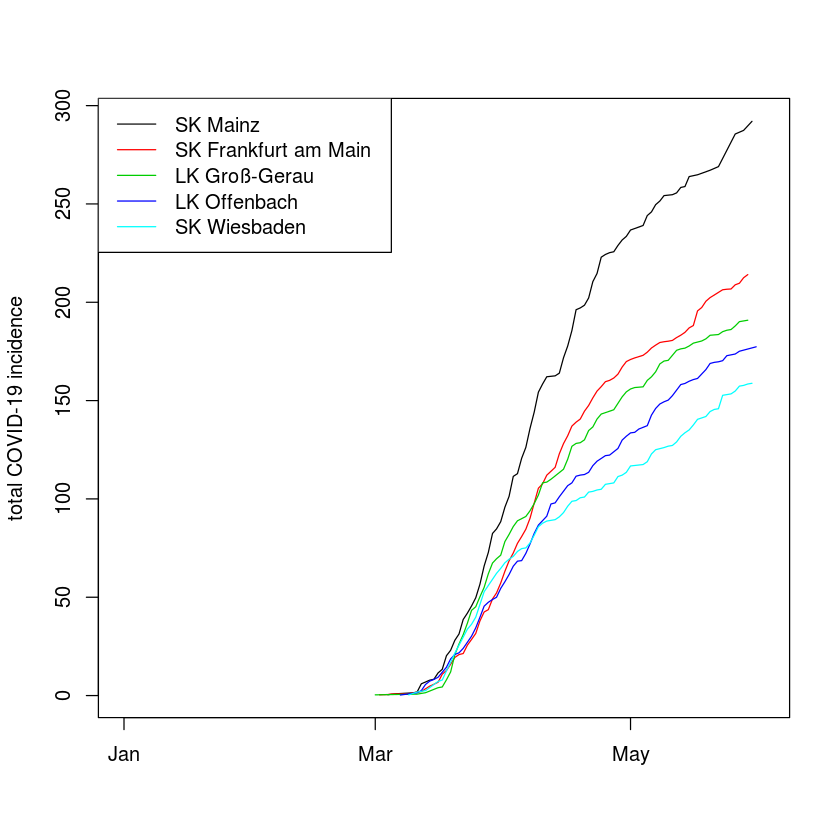

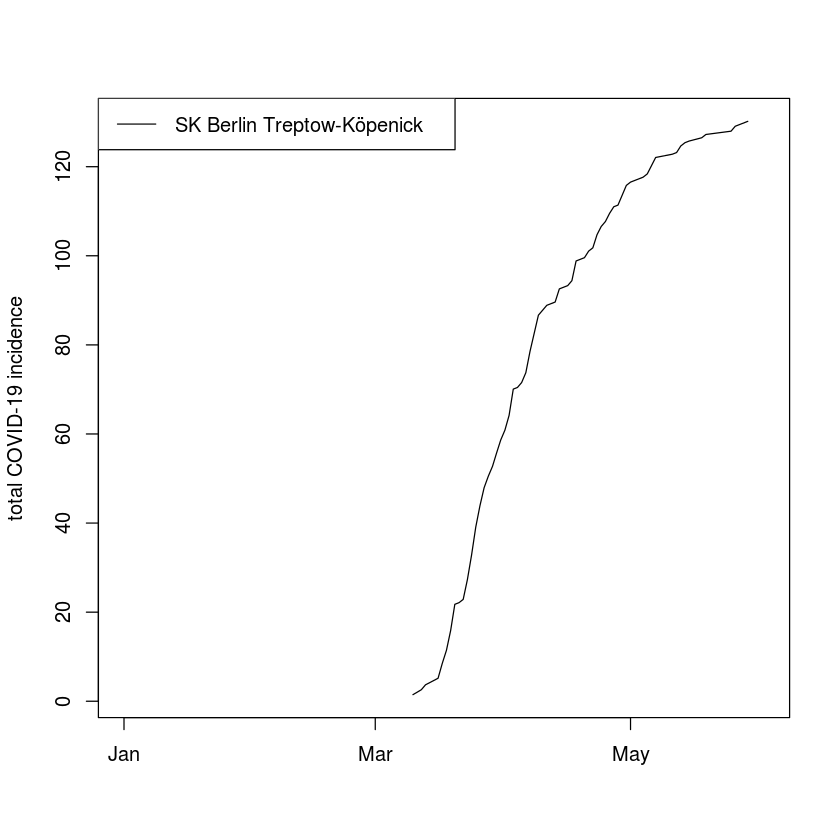

In [36]:
#plot_cases(rki, incidence=TRUE)
plot_cases(rki, incidence=TRUE, cluster=rki_clus$`14`)
plot_cases(rki, incidence=TRUE, LK="SK Berlin Treptow-Köpenick")

In [20]:
sum(rki$INC)

[1] 0

In [21]:
rki[grep ("LK Saarlouis", rki$LK),]
sum(rki[grep ("LK Saarlouis", rki$LK),]$N)
548/195201*100000

,X,Y,T,LK,ID,POP,N
,<dbl>,<dbl>,<dttm>,<fct>,<int>,<int>,<int>
18515,6.775578,49.35534,2020-03-15,LK Saarlouis,10044,195201,5
18516,6.775578,49.35534,2020-04-04,LK Saarlouis,10044,195201,46
18517,6.775578,49.35534,2020-03-26,LK Saarlouis,10044,195201,11
18518,6.775578,49.35534,2020-04-09,LK Saarlouis,10044,195201,25
18519,6.775578,49.35534,2020-04-10,LK Saarlouis,10044,195201,15
18520,6.775578,49.35534,2020-03-18,LK Saarlouis,10044,195201,12
18521,6.775578,49.35534,2020-04-05,LK Saarlouis,10044,195201,14
18522,6.775578,49.35534,2020-04-06,LK Saarlouis,10044,195201,16
18523,6.775578,49.35534,2020-04-16,LK Saarlouis,10044,195201,15


[1] 548

[1] 280.7363

In [22]:
sum(sapply(split(rki$POP, rki$ID), mean))

[1] 83128805